In [1]:
!pip install hmmlearn

%matplotlib inline
from hmmlearn import hmm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import math
import scipy.stats as stats
import statsmodels.api as sm
import gdown

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.9/165.9 kB 2.1 MB/s eta 0:00:00


In [8]:
url = 'https://raw.githubusercontent.com/kumarbirendra/Hidden-Makov-Model/refs/heads/main/NIFTY%2050.csv'
data_csv = pd.read_csv(url)

In [10]:
#data_csv = pd.read_csv(r"C:/Users/91797/Desktop/NIFTY 50.csv")

data = data_csv[data_csv.columns[0:5]]
data = data[:5348]

# Convert 'Date' column to datetime type
data['Date'] = pd.to_datetime(data['Date'])

# Set the 'Date' column as the index
data.set_index('Date', inplace=True)

# Resample the data to monthly frequency
obs = data.resample('M').agg({'Open': 'first','High': 'max','Low': 'min','Close': 'last'})

# Reset the index to have 'Date' as a column again
obs = obs.reset_index()

# Print the monthly data
print(obs)

data = obs[:162]
print(data)

          Date      Open      High       Low     Close
0   2000-01-31   1482.15   1671.15   1482.15   1546.20
1   2000-02-29   1546.20   1818.15   1521.40   1654.80
2   2000-03-31   1661.50   1773.85   1489.10   1528.45
3   2000-04-30   1528.70   1636.95   1311.30   1406.55
4   2000-05-31   1410.00   1436.60   1201.50   1380.45
..         ...       ...       ...       ...       ...
253 2021-02-28  13758.60  15431.75  13661.75  14529.15
254 2021-03-31  14702.50  15336.30  14264.40  14690.70
255 2021-04-30  14798.40  15044.35  14151.40  14631.10
256 2021-05-31  14481.05  15606.35  14416.25  15582.80
257 2021-06-30  15629.65  15915.65  15450.90  15721.50

[258 rows x 5 columns]
          Date     Open     High      Low    Close
0   2000-01-31  1482.15  1671.15  1482.15  1546.20
1   2000-02-29  1546.20  1818.15  1521.40  1654.80
2   2000-03-31  1661.50  1773.85  1489.10  1528.45
3   2000-04-30  1528.70  1636.95  1311.30  1406.55
4   2000-05-31  1410.00  1436.60  1201.50  1380.45
..        

<ipython-input-10-952646965561>:13: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  obs = data.resample('M').agg({'Open': 'first','High': 'max','Low': 'min','Close': 'last'})


# Finding the Optimal Hidden state

In [11]:
# Remove any rows with missing values
obs = obs.dropna()

# Select the first four columns as observations
obs = obs[obs.columns[1:5]]
# Set the number of observations to consider for each iteration
T = 96

# Initialize empty lists to store the evaluation criteria results
AIC, BIC, HQC, CAIC = [], [], [], []

# Iterate over different number of components for the HMM model
for n in range(2, 7):
    # Initialize empty lists to store the evaluation criteria values for each iteration
    a, b, c, d = [], [], [], []

    # Flag to check if it is the first iteration
    first_time = True

    # Iterate over the data with a sliding window of size T
    for i in range(0, T):
        # Define the HMM model
        if first_time:
            # For the first iteration, create a new model
            model = hmm.GaussianHMM(n_components=n, n_iter=100)
            first_time = False
        else:
            # For subsequent iterations, create a new model and initialize its parameters
            old_model = model
            model = hmm.GaussianHMM(n_components=n, init_params="c", n_iter=100)
            model.startprob_ = old_model.startprob_
            model.transmat_ = old_model.transmat_
            model.means_ = old_model.means_

        # Train the model using the Baum-Welch algorithm
        model.fit(obs[i:i+T])

        # Perform the forward algorithm to compute log-likelihoods and forward probabilities
        log_likelihoods, fwd = model.score_samples(obs[i:i+T])

        # Calculate the number of parameters for the model
        k = n**2 + 2*n - 1

        # Calculate AIC (Akaike Information Criterion)
        aic = -2 * log_likelihoods + 2 * k

        # Calculate BIC (Bayesian Information Criterion)
        bic = -2 * log_likelihoods + k * np.log(4 * T)

        # Calculate HQC (Hannan-Quinn Criterion)
        hqc = -2 * log_likelihoods + k * (np.log(np.log(4 * T)))

        # Calculate CAIC (Consistent Akaike Information Criterion)
        caic = -2 * log_likelihoods + k * (np.log(4 * T) + 1)

        # Append the evaluation criteria values to the corresponding lists
        a.append(aic)
        b.append(bic)
        c.append(hqc)
        d.append(caic)

    # Append the evaluation criteria lists for the current number of components to the main lists
    AIC.append(a)
    BIC.append(b)
    HQC.append(c)
    CAIC.append(d)

/usr/local/lib/python3.11/dist-packages/hmmlearn/hmm.py:352: RuntimeWarning: invalid value encountered in divide
  self.means_ = ((means_weight * means_prior + stats['obs'])


ValueError: startprob_ must sum to 1 (got nan)

IndexError: list index out of range

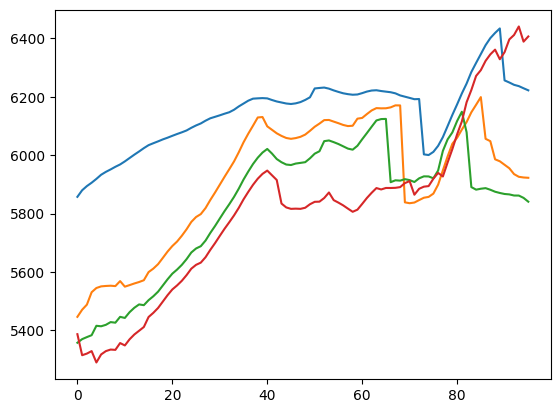

In [12]:
# Plot AIC values for different numbers of components
for i in range(0, 5):
    plt.plot(AIC[i], label=f"{i+2}-State")
plt.ylabel("AIC")

plt.legend()
plt.show()

# Plot BIC values for different numbers of components
for i in range(0, 5):
    plt.plot(BIC[i], label=f"{i+2}-State")
plt.ylabel("BIC")
plt.legend()
plt.show()

# Plot HQC values for different numbers of components
for i in range(0, 5):
    plt.plot(HQC[i], label=f"{i+2}-State")
plt.ylabel("HQC")
plt.legend()
plt.show()

# Plot CAIC values for different numbers of components
for i in range(0, 5):
    plt.plot(CAIC[i], label=f"{i+2}-State")
plt.ylabel("CAIC")
plt.legend()
plt.show()

# Predicting using HMM

T=  162
HMM Prices: 
[5742.0, 5471.8, 5735.3, 6299.15, 6176.1, 6304.0, 6176.1, 5902.05, 5849.7, 6576.3, 6573.35, 7106.900000000001, 7047.500000000001, 7457.8, 7690.85, 7607.4, 8052.000000000001, 8893.8, 8182.500000000001, 8427.5, 8638.35, 8901.85, 8562.900000000001, 8498.8, 8275.55, 8522.400000000001, 8115.05, 8330.3, 7937.900000000001, 8316.650000000001, 7420.1500000000015, 7258.000000000001, 7253.099999999999, 7849.8, 8160.1, 8287.75, 8638.5, 8786.2, 8611.15, 8625.7, 8224.5, 8263.2, 7810.300000000001, 8242.999999999998, 8840.900000000001, 9165.95, 9451.75, 9446.199999999999, 9498.5, 9515.55, 10034.8, 9900.0, 10881.999999999998, 10536.849999999999, 10658.35, 11574.4, 10989.85, 10739.35, 11049.650000000001, 11361.8, 11356.5, 11367.6, 11691.6, 10386.6, 10876.75, 11366.9, 11186.55, 10080.900000000001, 10661.95, 11585.449999999999, 12579.55, 11788.85, 11785.65, 10583.15, 11001.4, 12225.8, 11342.6, 12167.45, 12146.6, 12286.1, 8597.75, 8594.55, 10262.9, 9558.449999999999, 10927.75, 11904.85

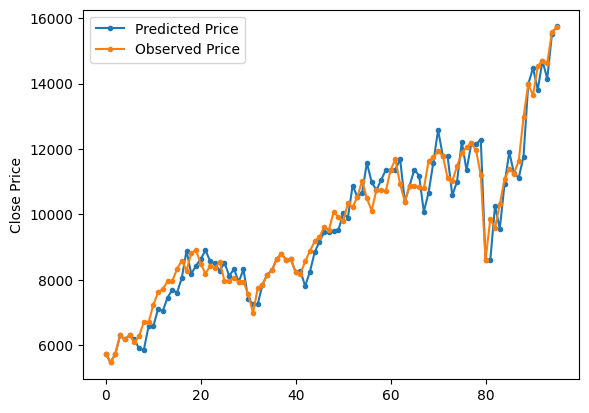

In [13]:
data = data[data.columns[1:5]]
obs = obs[obs.columns[1:5]]
# Calculate number of rows and set training window
T = data.shape[0]
print("T= ", T)

# Define the size of the training window
d = 96
D = 96
hmm_price = []

temp_T = T
first_time = True

# Sliding window approach to predict future prices
while T < temp_T + d:

    # Train HMM on data from T-D+1 to T
    train_data = obs.iloc[T-D:T]
    train_data = train_data.dropna()

    # Set the random seed
    np.random.seed(123)

    if(first_time):
      first_time = False
      model = hmm.GaussianHMM(n_components=5)
    else:
      old_model= model
      model = hmm.GaussianHMM(n_components=5, init_params="c")
      model.startprob_ = old_model.startprob_
      model.transmat_ = old_model.transmat_
      model.means_ = old_model.means_

    model.fit(train_data)

    # Calculate original likelihood
    original_likelihood = model.score(train_data)

    # Loop to find new likelihood
    t=T
    min_diff = float('inf')
    min_t = T
    min_likelihood = original_likelihood
    while t-D>  0:
        t = t-1

        train_data = obs.iloc[t-D:t]
        new_likelihood = model.score(train_data)
        if (abs(new_likelihood - original_likelihood))< min_diff:  # Threshold for comparison by choosing that new_likelihood which is minimum
            min_diff = abs(new_likelihood - original_likelihood)
            min_t = t
            min_likelihood = new_likelihood

    # Calculate the predicted close price
    close_price = obs['Close'][T-1] + ((obs['Close'][min_t + 1] - obs['Close'][min_t]) * np.sign(original_likelihood - min_likelihood))

    hmm_price.append(close_price)
    T=T+1

# Print the calculated prices
print("HMM Prices: ")
print(hmm_price)

# Plot the predicted and observed prices
close = []
truncated_obs = obs.iloc[T-d:T]

for i in truncated_obs['Close']:
  close.append(i)

plt.plot(hmm_price,marker='.', label = "Predicted Price")
plt.plot(close,marker = '.', label= "Observed Price")
plt.ylabel("Close Price")
plt.legend()
plt.show()

# HMM vs HAR Returns (Out_of_sample R^2 based on stock Returns) R^2_OSR

In [14]:
m = d // 2

# Calculating the monthly return of closing price
close_return = [(close[i] - close[i-1]) / close[i-1] if i> 0 else 0 for i in range(d)]

#The real stock returns at each time step.
real_return=[(close[i] - close[i-1]) / close[i-1] for i in range(m+1, d)]

#The relative stock return based on the HMM model.
pred_return = [(hmm_price[i]-close[i-1])/close[i-1] for i in range(m+1,d)]

#The predicted stock returns based on the historical average return method.
har_return = [np.mean(close_return[:i]) for i in range(m+1,d)]
# har_return = [(np.mean(close[:i]) - close[i-1])/close[i-1] for i in range(m+1,D)]

# Calculate the squared errors between real return and predicted returns
squared_error_hmm_r = np.square( np.array(real_return) - np.array(pred_return))
squared_error_har_r = np.square(np.array(real_return) - np.array(har_return))

# Calculate the out-of-sample R2 for stock return based on predicted retur (R2_OSR)
r2_osr = 1 - np.sum(squared_error_hmm_r)/np.sum(squared_error_har_r)

print(r2_osr, 1 - np.sum(squared_error_hmm_r), 1 - np.sum(squared_error_har_r))


0.1891477761001693 0.8708916121800295 0.8407744543154636


# HMM vs HAR Price (Out_of_sample R^2 based on stock Price) R^2_OSP

In [15]:
m = D // 2

#The real stock prices at each time step.
real_price=[close[i] for i in range(m+1,D)]

#The predicted stock prices based on the HMM model.
pred_price = [hmm_price[i] for i in range(m+1,D)]

#The predicted stock prices based on the historical average return method.
har_return_new = [np.mean(close_return[:i]) if i > 0 else 0 for i in range(D)]
har_price = [close[i-1]*(har_return_new[i]+1) for i in range(m+1,D)]

# Calculate the squared errors between real price and predicted price
squared_error_hmm = np.square(np.array(real_price) - np.array(pred_price))
squared_error_har = np.square(np.array(real_price) - np.array(har_price))

# Calculate the out-of-sample R2 for stock price based on predicted price (R2_OSP)
r2_osp = 1 - np.sum(squared_error_hmm)/np.sum(squared_error_har)

print(r2_osp)

0.21909774179934627


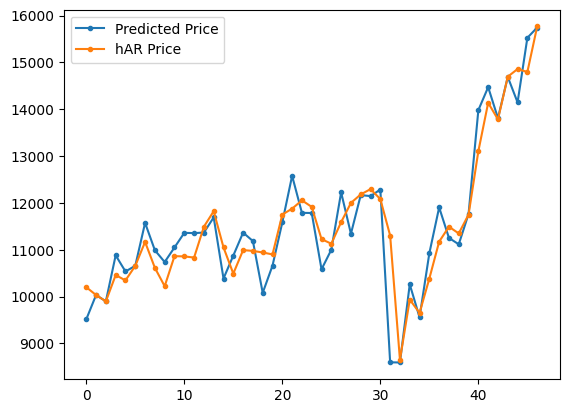

In [16]:
plt.plot(pred_price,marker='.', label = "Predicted Price")
# plt.plot(real_price,marker = '.', label= "Observed Price")
plt.plot(har_price,marker = '.', label= "hAR Price")
plt.legend()
plt.show()

Text(0.5, 1.0, 'R2OSP, and R2OSR of Nifty-50 monthly prices')

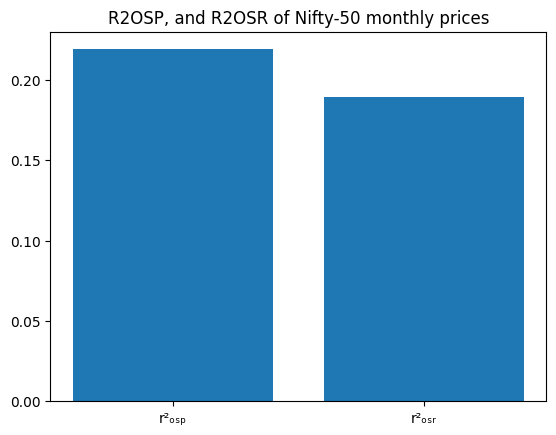

In [17]:
# plt.plot(r2_osp,r2_osr)
x = ['r\u00b2\u2092\u209B\u209A', 'r\u00b2ₒₛᵣ']
y = [r2_osp, r2_osr]

plt.bar(x, y)
plt.title('R2OSP, and R2OSR of Nifty-50 monthly prices')

# Regression on Returns

In [18]:
# Convert the lists to numpy arrays
real_return = np.array(real_return)
pred_return = np.array(pred_return)
har_return = np.array(har_return)

# Calculate f_t+1 values
f_values = np.square(real_return - har_return) - (np.square(real_return - pred_return) - np.square(har_return - pred_return))

# Perform regression of f_t+1 on a constant
constant = [1]*len(f_values)
X = np.column_stack((constant,))
model = sm.OLS(f_values, X)
results = model.fit()
p_value = results.pvalues
t_values = results.tvalues

# Perform MSPE-adjusted test
alpha = 0.001  # Significance level
if p_value <= alpha:
    print("Reject the null hypothesis R2_OSR = 0")
    print("Accept the alternate hypothesis R2_OSR > 0")
else:
    print("Failed to reject the null hypothesis R2_OSR = 0")

# Print the p-value of the constant term for both tests
print("P-value for R2_OSR constant:", results.pvalues)

Failed to reject the null hypothesis R2_OSR = 0
P-value for R2_OSR constant: [0.20073505]


# Regression on Price

In [19]:
# Convert the lists to numpy arrays
real_price = np.array(real_price)
pred_price = np.array(pred_price)
har_price = np.array(har_price)

# Calculate f_t+1 values
f_values = np.square(real_price - har_price) - (np.square(real_price - pred_price) - np.square(har_price - pred_price))

# Perform regression of f_t+1 on a constant
constant = [1]*len(f_values)
X = np.column_stack((constant,))
model = sm.OLS(f_values, X)
results = model.fit()
p_value = results.pvalues
t_values = results.tvalues

# Perform MSPE-adjusted test
alpha = 0.001  # Significance level
if p_value <= alpha:
    print("Reject the null hypothesis R2_OSP = 0")
    print("Accept the alternate hypothesis R2_OSP > 0")
else:
    print("Failed to reject the null hypothesis R2_OSP = 0")

# Print the p-value of the constant term for both tests
print("P-value for R2_OSP constant:", results.pvalues)

Failed to reject the null hypothesis R2_OSP = 0
P-value for R2_OSP constant: [0.1841184]



# Calculating CSPE Returns

[0, -6.003068369301191e-07, 7.6276066095363245e-06, -0.0035004800713136957, -0.003175985944255128, -0.003171037613558944, -0.0090455762970222, -0.013739468498333945, -0.011128104211143214, -0.011837716802383795, -0.015293495455622166, -0.01291943532192518, -0.013405767805559004, -0.011800913905869646, -0.008101751448541767, -0.006727144345353072, -0.00873349902568339, -0.00962526540809652, -0.013749917093322787, -0.01721398371814892, -0.01740975551880542, -0.02052038212894125, -0.02002073990149449, -0.01864311383811568, -0.01987140622841409, -0.020733284521322386, -0.021026284457929322, -0.0246127006859907, -0.024611462505119485, -0.024091556390752236, -0.026885723284497707, 0.031495074266934237, 0.02961094274274238, 0.026131989887758007, 0.02471564863293144, 0.02895280446848869, 0.027143166592951136, 0.02760768128050955, 0.02610600728665489, 0.026387565177809873, 0.030957435853066935, 0.028672481731580907, 0.02888343035808926, 0.028883535533627595, 0.028037126022152165, 0.030913230745

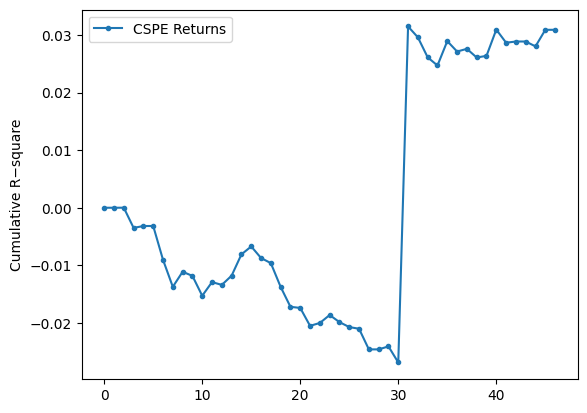

In [20]:
m = D//2  # Out of Sample Range

cspe_r = []  # List to store the CSPE (Cumulative Squared Prediction Error) for returns

# Calculate CSPE for each value of i
for i in range(m, D-1):
    sum_val = 0

    # Calculate the sum of squared errors for each lag value
    for j in range(m+1, i+1):
        sum_val += (np.square(real_return[j-m] - har_return[j-m]) - np.square(real_return[j-m] - pred_return[j-m]))

    cspe_r.append(sum_val)  # Append the CSPE value to the list

print(cspe_r)

# Plot the CSPE returns
plt.plot(cspe_r, marker='.', label="CSPE Returns")
plt.ylabel("Cumulative R−square")
plt.legend()
plt.show()


# Calculating CSPE Price

[0, -59.04902618123742, 729.322405537052, -374001.21830446745, -340064.8680794755, -339516.1197676695, -1053919.7518152124, -1570716.8190593105, -1303608.3890431847, -1385450.5910613788, -1783780.6300838708, -1511247.4900232318, -1573969.8353016581, -1355013.069561915, -913056.6071033122, -764761.986489772, -1002121.1497501933, -1107345.117357012, -1591205.8530805726, -1994693.6002608184, -2021145.3171319952, -2450470.979648117, -2379445.258227064, -2187986.9424146004, -2339816.0714291655, -2444544.661516975, -2483121.9129915857, -2989071.345023537, -2988891.377487302, -2911908.2680339958, -3311730.7400960596, 4013845.2108107703, 3874567.7496331115, 3536352.205112914, 3406357.3623164454, 3856060.542958018, 3634160.4033549945, 3694396.418044552, 3504423.5739624347, 3542587.472836132, 4311210.766182182, 3864526.6088944664, 3903742.4473640895, 3903764.649520536, 3721095.370268479, 4336780.483194773]


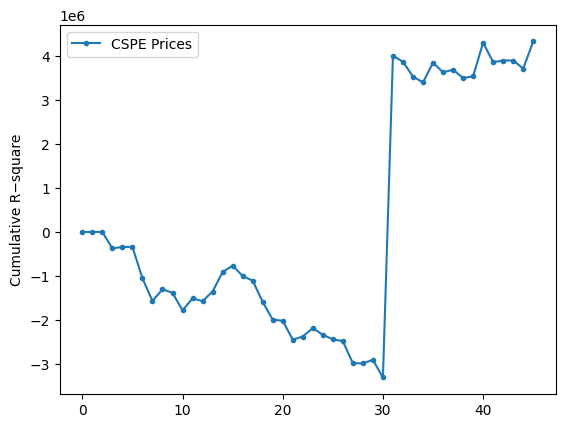

In [21]:

m = D//2 # Out of sample range

cspe_p = []  # List to store the CSPE (Cumulative Squared Prediction Error) for prices

# Calculate CSPE for each value of i
for i in range(m, D-2):
    sum_val = 0

    # Calculate the sum of squared errors for each lag value
    for j in range(m+1, i+1):
        sum_val += (np.square(real_price[j-m] - har_price[j-m]) - np.square(real_price[j-m] - pred_price[j-m]))

    cspe_p.append(sum_val)  # Append the CSPE value to the list

print(cspe_p)

# Plot the CSPE prices
plt.plot(cspe_p, marker='.', label="CSPE Prices")
plt.ylabel("Cumulative R−square")
plt.legend()
plt.show()


# APE Error Estimator

In [22]:
N = m-1  # Number of data points

# Function to calculate Absolute Percentage Error (APE)
def ape(real_, pred_):
    APE = 0
    sum = 0

    # Calculate the sum of absolute differences between real and predicted values
    for i in range(1, N):
        sum += (np.abs(real_[i] - pred_[i])) / N

    # Calculate APE as a ratio of the sum to the mean of real values
    APE = sum / (np.mean(real_))

    return APE

# Calculate APE for HMM-based price predictions
ape_hmm_price = ape(real_price, pred_price)

# Calculate APE for Harmonic-based price predictions
ape_har_price = ape(real_price, har_price)

# Calculate APE for HMM-based return predictions
ape_hmm_return = ape(real_return, pred_return)

# Calculate APE for Harmonic-based return predictions
ape_har_return = ape(real_return, har_return)

# Calculate efficiency ratios
eff_price = 1 - ape_hmm_price / ape_har_price
eff_return = 1 - ape_hmm_return / ape_har_return

# Print the calculated APEs and efficiency ratios
print("ape_hmm_price=", ape_hmm_price, "ape_har_price=", ape_har_price, "ape_eff_price=", eff_price)
print("ape_hmm_return=", ape_hmm_return, "ape_har_return=", ape_har_return, "ape_eff_return=", eff_return)

ape_hmm_price= 0.037251313645782824 ape_har_price= 0.03921664985650827 ape_eff_price= 0.050114841984629344
ape_hmm_return= 3.4536402537842035 ape_har_return= 3.6046964357198634 ape_eff_return= 0.041905382222704124


# AAE Error Estimator

In [23]:
N = m-2
def aae(real_, pred_):
  AAE = 0
  sum = 0
  for i in range(1,N):
    sum += (np.abs(real_[i] - pred_[i]))/N
  AAE = sum
  return AAE

aae_hmm_price = aae(real_price, pred_price)
aae_har_price = aae(real_price, har_price)
aae_hmm_return = aae(real_return, pred_return)
aae_har_return = aae(real_return, har_return)
aae_eff_price = 1 - aae_hmm_price/aae_har_price
aae_eff_return = 1 - aae_hmm_return/aae_har_return
print("aae_hmm_price=",aae_hmm_price, "aae_har_price=",aae_har_price, "aae_eff_price=",aae_eff_price)
print("aae_hmm_return=",aae_hmm_return,"aae_har_return=", aae_har_return, "aae_eff_return=",aae_eff_return)

aae_hmm_price= 438.207608695652 aae_har_price= 460.85388258043525 aae_eff_price= 0.04913981359553943
aae_hmm_return= 0.03970480872939207 aae_har_return= 0.04141078268561862 aae_eff_return= 0.041196370741840904


# ARPE Error Estimation

In [24]:
N = m-2
def arpe(real_, pred_):

  sum = 0
  for i in range(1,N):
    sum += (np.abs(real_[i] - pred_[i]))/N
  ARPE = sum/N
  return ARPE

arpe_hmm_price = arpe(real_price, pred_price)
arpe_har_price = arpe(real_price, har_price)
arpe_hmm_return = arpe(real_return, pred_return)
arpe_har_return = arpe(real_return, har_return)
arpe_eff_price = 1 - arpe_hmm_price/arpe_har_price
arpe_eff_return = 1 - arpe_hmm_return/arpe_har_return
print("arpe_hmm_price=",arpe_hmm_price, "arpe_har_price=",arpe_har_price, "arpe_eff_price=",arpe_eff_price)
print("arpe_hmm_return=",arpe_hmm_return,"arpe_har_return=", arpe_har_return, "arpe_eff_return=",arpe_eff_return)

arpe_hmm_price= 9.526252362948957 arpe_har_price= 10.018562664792071 arpe_eff_price= 0.04913981359553954
arpe_hmm_return= 0.0008631480158563493 arpe_har_return= 0.0009002344062091004 arpe_eff_return= 0.041196370741840904


# RMSE Error Estimate

In [25]:
N = m-2
def rmse(real_, pred_):
  sum = 0
  for i in range(1,N):
    sum += (np.square(real_[i] - pred_[i]))
  RMSE = np.sqrt(sum/N)
  return RMSE

rmse_hmm_price = rmse(real_price, pred_price)
rmse_har_price = rmse(real_price, har_price)
rmse_hmm_return = rmse(real_return, pred_return)
rmse_har_return = rmse(real_return, har_return)
rmse_eff_price = 1 - rmse_hmm_price/rmse_har_price
rmse_eff_return = 1 - rmse_hmm_return/rmse_har_return
print("rmse_hmm_price=",rmse_hmm_price, "rmse_har_price=",rmse_har_price, "rmse_eff_price=",rmse_eff_price)
print("rmse_hmm_return=",rmse_hmm_return,"rmse_har_return=", rmse_har_return, "rmse_eff_return=",rmse_eff_return)

rmse_hmm_price= 571.2262214154814 rmse_har_price= 648.5192615673026 rmse_eff_price= 0.11918387738403324
rmse_hmm_return= 0.0526497985823672 rmse_har_return= 0.05868584195620609 rmse_eff_return= 0.10285348514456427
